# RBMs and Autoencoders

In [1]:
import urllib.request
with urllib.request.urlopen("http://deeplearning.net/tutorial/code/utils.py") as url:
    response = url.read()
target = open('utils.py', 'w')
target.write(response.decode('utf-8'))
target.close()

%tensorflow_version 1.x  

import tensorflow as tf
print(tf.__version__)
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
#!pip install pillow
from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 1.x selected.
1.15.2


## RBM

An example of a Restricted Boltzman Machine


For this example we will use the MNIST dataset

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trainX, trainY, testX, testY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
trainX[1].shape

(784,)

We create the placeholders for the biasses and the weights

In [6]:
vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [50])
W = tf.placeholder("float", [784, 50])

And we define the visible and hidden layers

In [7]:
v0_state = tf.placeholder("float", [None, 784])

h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)  #probabilities of the hidden units
h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random_uniform(tf.shape(h0_prob)))) #sample_h_given_X

And finally the reconstruction part

In [8]:
v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random_uniform(tf.shape(v1_prob)))) #sample_v_given_h

In [9]:
h1_prob = tf.nn.sigmoid(tf.matmul(v1_state, W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random_uniform(tf.shape(h1_prob)))) #sample_h_given_X

With all the states defined, we choose our objective function to be mean square error

In [10]:
err = tf.reduce_mean(tf.square(v0_state - v1_state))

and we define the training functions

In [11]:
alpha = 0.01
W_Delta = tf.matmul(tf.transpose(v0_state), h0_prob) - tf.matmul(tf.transpose(v1_state), h1_prob)
update_w = W + alpha * W_Delta
update_vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
update_hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)

Let's now initialize the variables

In [12]:
cur_w = np.zeros([784, 50], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([50], np.float32)
prv_w = np.zeros([784, 50], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([50], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Now we are ready to train the model

Epoch: 0 reconstruction error: 0.130318
Epoch: 1 reconstruction error: 0.123739
Epoch: 2 reconstruction error: 0.127470
Epoch: 3 reconstruction error: 0.106634
Epoch: 4 reconstruction error: 0.096758


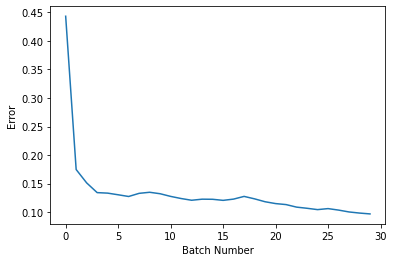

In [13]:
#Parameters
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(trainX), batchsize), range(batchsize, len(trainX), batchsize)):
        batch = trainX[start:end]
        cur_w = sess.run(update_w, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={v0_state: trainX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print ('Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

We can take a look at the learned features of each of the 50 hidden units

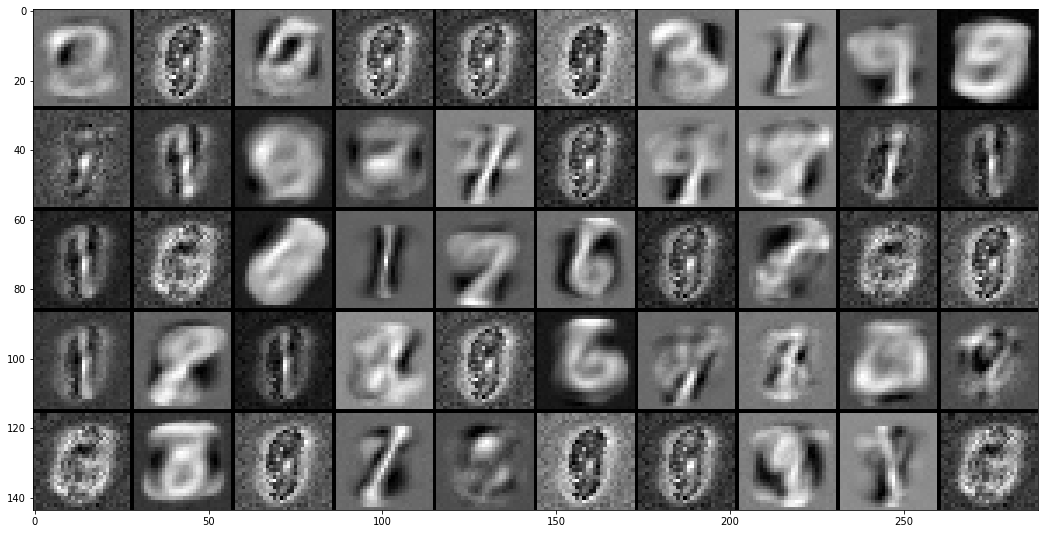

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

We can now use the RBM to reconstruct a a destructed image

--2020-08-19 02:47:23--  https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Resolving ibm.box.com (ibm.box.com)... 107.152.24.197
Connecting to ibm.box.com (ibm.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg [following]
--2020-08-19 02:47:23--  https://ibm.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg [following]
--2020-08-19 02:47:23--  https://ibm.ent.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.29.201
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b

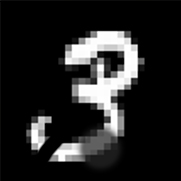

In [15]:
!wget -O destructed3.jpg  https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
img = Image.open('destructed3.jpg')
img

We pass the image through the net and plot it

Probability nodes in hidden layer: [[1.0000000e+00 0.0000000e+00 8.8613141e-01 0.0000000e+00 8.9406967e-08
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00 2.5626451e-02 0.0000000e+00 1.0000000e+00 0.0000000e+00
  4.4703484e-07 0.0000000e+00 9.9834102e-01 2.6845932e-04 3.2424927e-04
  1.1321306e-03 2.9802322e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 9.2387199e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.7553568e-05 0.0000000e+00 7.8022480e-05 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 4.0740627e-01 8.8802314e-01 1.4618039e-04
  1.1920929e-07 2.3812056e-05 0.0000000e+00 0.0000000e+00 9.9999934e-01
  0.0000000e+00 1.1920929e-07 0.0000000e+00 0.0000000e+00 4.8373732e-08]]
activated nodes in hidden layer: [[1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0.]]


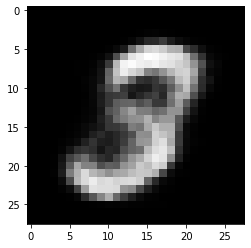

In [16]:
# convert the image to a 1d numpy array
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0

hh0_p = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)
hh0_s = tf.nn.relu(tf.sign(hh0_p - tf.random_uniform(tf.shape(hh0_p)))) 
hh0_p_val,hh0_s_val  = sess.run((hh0_p, hh0_s), feed_dict={ v0_state: sample_case, W: prv_w, hb: prv_hb})
print("Probability nodes in hidden layer:" ,hh0_p_val)
print("activated nodes in hidden layer:" ,hh0_s_val)

# reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s_val, tf.transpose(W)) + vb)
rec_prob = sess.run(vv1_p, feed_dict={ hh0_s: hh0_s_val, W: prv_w, vb: prv_vb})

img = Image.fromarray(tile_raster_images(X=rec_prob, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')

## Autoencoder

This is a basic example of an autoencoder applied on the same dataset. We first define all the parameters.

In [17]:
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

and then we build the encoder and decoder

In [18]:
# Building the encoder
def encoder(x):
    # Encoder first layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    # Encoder second layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

In [19]:
# Building the decoder
def decoder(x):
    # Decoder first layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),biases['decoder_b1']))
    # Decoder second layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2

following by the construction of the model

In [20]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Reconstructed Images
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
sess = tf.InteractiveSession()
sess.run(init)

total_batch = int(mnist.train.num_examples / batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

Epoch: 0001 cost= 0.192188248
Epoch: 0002 cost= 0.163810939
Epoch: 0003 cost= 0.150519937
Epoch: 0004 cost= 0.137034178
Epoch: 0005 cost= 0.124907881
Epoch: 0006 cost= 0.116811000
Epoch: 0007 cost= 0.114610747
Epoch: 0008 cost= 0.107463524
Epoch: 0009 cost= 0.108080238
Epoch: 0010 cost= 0.102340274
Epoch: 0011 cost= 0.103956752
Epoch: 0012 cost= 0.101485245
Epoch: 0013 cost= 0.100249581
Epoch: 0014 cost= 0.097723491
Epoch: 0015 cost= 0.098238222
Epoch: 0016 cost= 0.094785340
Epoch: 0017 cost= 0.095583737
Epoch: 0018 cost= 0.092564307
Epoch: 0019 cost= 0.090540186
Epoch: 0020 cost= 0.088204615
Optimization Finished!


And finally we can test the model against the original images

In [22]:
# Applying encode and decode over test set
encode_decode = sess.run(
    y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})

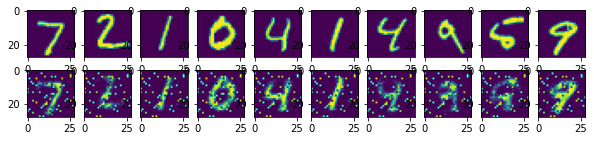

In [23]:
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))